In [1]:
import os, shutil

model_ver = str(2)
base_dir = os.getcwd()
csv_dir = os.path.join(base_dir, 'img_csv')
data_dir = os.path.join(base_dir, 'data')

train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

model_dir = os.path.join(base_dir, 'models')
model_nm_dir = os.path.join(model_dir, 'EfficientNet_{}.h5'.format(model_ver))
pred_dir = os.path.join(base_dir, 'img_predict')

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
target_size = (600,600)
batch_size = 16
epochs = 100

In [4]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

Found 118781 images belonging to 167 classes.
Found 14855 images belonging to 167 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [6]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7
base_model = EfficientNetB7(classes = 167, include_top = True, weights = None)
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 600, 600, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 600, 600, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 601, 601, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [7]:
model = base_model

In [8]:
model.compile(loss='categorical_crossentropy',
        optimizer='SGD',
        metrics=['accuracy'])

In [9]:
model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 600, 600, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 600, 600, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 601, 601, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [10]:
history = model.fit(
        train_generator,
        steps_per_epoch=batch_size,
        epochs=epochs,
        validation_data = validation_generator,
        validation_steps=batch_size)

Epoch 1/100


ResourceExhaustedError:  OOM when allocating tensor with shape[16,288,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node efficientnetb7/block2c_expand_bn/FusedBatchNormV3 (defined at <ipython-input-10-91761a5e9db3>:6) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_49741]

Function call stack:
train_function


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
def smooth_curve(points, factor=0.99):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

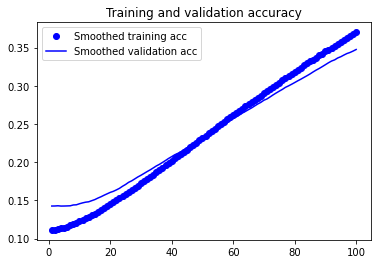

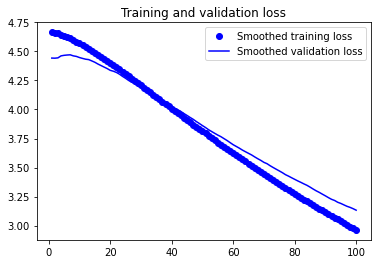

In [13]:
plt.plot(epochs,
        smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
        smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
        smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
        smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')
test_loss, test_acc = model.evaluate(test_generator, steps=72)
print('test acc:', test_acc)

Found 14889 images belonging to 167 classes.
  ...
    to  
  ['...']
72/72 [==============================] - 96s 1s/step - loss: 1.8357 - accuracy: 0.5551
test acc: 0.55512154


In [15]:
model.save(model_nm_dir)